## Can we do spectral estimation using GP for scattered data?

### 1. Load and check out spectra

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xrft

In [2]:
ds = xr.open_dataset('../data/1km_submeso_data.nc')

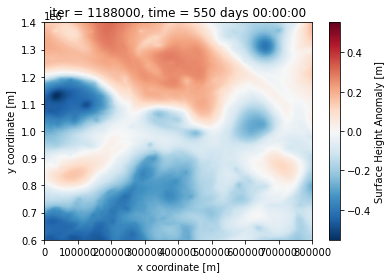

In [3]:
ds.Eta.sel(XC=slice(0,800e3), YC=slice(600e3,1400e3)).isel(time=0).plot()

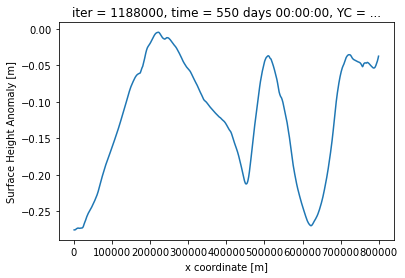

In [4]:
ds.Eta.sel(XC=slice(0,800e3)).sel(YC=1000e3, method='nearest').isel(time=0).plot()

In [5]:
eta_sel = ds.Eta.sel(XC=slice(0,800e3), YC=slice(600e3,1400e3))

In [6]:
eta_sel = eta_sel.isel(XC=range(0,800,10), YC=range(0,800,10))

In [7]:
eta_ps = xrft.isotropic_powerspectrum(eta_sel, dim=['XC','YC'], window='True')

/home/dbalwada/miniconda/envs/sogos/lib/python3.8/site-packages/xrft/xrft.py:589: RuntimeWarning: invalid value encountered in true_divide
  kr = np.bincount(kidx, weights=K.ravel()) / area
/home/dbalwada/miniconda/envs/sogos/lib/python3.8/site-packages/xrft/xrft.py:598: RuntimeWarning: invalid value encountered in true_divide
  iso_f = np.ma.masked_invalid(np.bincount(kidx, weights=f)


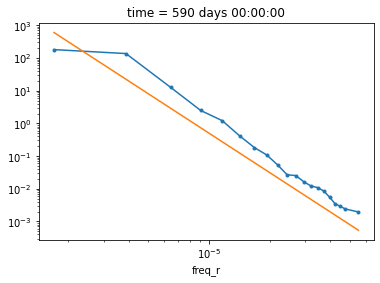

In [8]:
eta_ps.isel(time=1).plot(marker='.')
plt.plot(eta_ps.freq_r, 5e-21*eta_ps.freq_r**-4)
plt.xscale('log')
plt.yscale('log')

### 2. Estimate spectra with full data and correct kernel

In [9]:
# Extract data into a form that we like
num_samples = len(eta_sel.XC)*len(eta_sel.YC)
[XCg, YCg]  = np.meshgrid(eta_sel.XC.values, eta_sel.YC.values)

Xinput = np.zeros((num_samples, 2)) # 3 coordinates for lon, lat, time
Xinput[:,0] = XCg.reshape(-1)
Xinput[:,1] = YCg.reshape(-1)

Yinput = eta_sel.isel(time=0).values.reshape(-1)

In [149]:
gp = george.GP(kernel, fit_white_noise=True)

In [150]:
test_pts = np.array(np.meshgrid(np.linspace(0,800e3,80), 
                       np.linspace(600e3,1400e3,80),
                       )).reshape(2,-1).T

In [151]:
gp.compute(Xinput, 0.001)

In [152]:
pred, pred_var = gp.predict(Yinput, test_pts, return_var=True)

In [153]:
nx = len(eta_sel.XC)
pred_xr = xr.DataArray(pred.reshape(nx,nx),  
                           coords= [('XC',eta_sel.XC), 
                                    ('YC',eta_sel.YC)]) 

Text(0.5, 1.0, 'Truth')

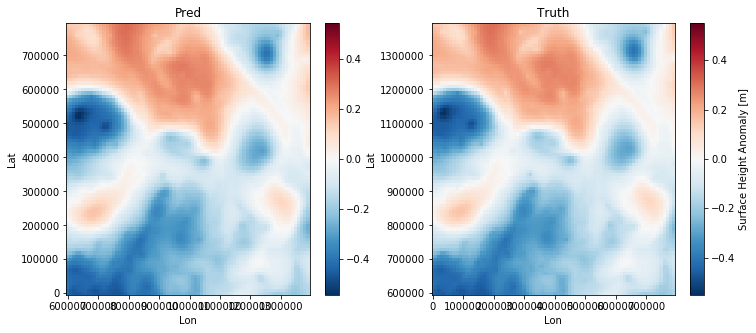

In [154]:
plt.figure(figsize=(12,5))

plt.subplot(121)
#plt.scatter(test_pts[:,0], 
#            test_pts[:,1],
#            c=pred,
#            s=50, marker='s',  cmap='RdBu_r')
pred_xr.plot()
plt.xlabel('Lon')
plt.ylabel('Lat')
#plt.colorbar()
plt.title('Pred')

plt.subplot(122)
#plt.scatter(Xinput[:,0], 
#            Xinput[:,1],
#            c=Yinput,
#            s=50, marker='s',  cmap='RdBu_r')
eta_sel.isel(time=0).plot()
plt.xlabel('Lon')
plt.ylabel('Lat')
#plt.colorbar()
plt.title('Truth')

In [155]:
print("Initial ln-likelihood: {0:.2f}".format(
    gp.log_likelihood(Yinput)))

Initial ln-likelihood: 25197.76


In [156]:
from scipy.optimize import minimize

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(Yinput)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(Yinput)

# these functions could probably be written better, and not be so hard coded,
# needed to change the insides because things were named with "_argo" here.

In [158]:
%%time 
result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)

CPU times: user 10min 14s, sys: 38.4 s, total: 10min 53s
Wall time: 8min 42s


In [159]:
# Let's set the parameters to be these new ones, derived from MLE
gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(Yinput)))


Final ln-likelihood: 25564.21


In [160]:
pred_MLE, pred_var_MLE = gp.predict(Yinput, test_pts, return_var=True)

In [161]:
nx = len(eta_sel.XC)
pred_MLE_xr = xr.DataArray(pred_MLE.reshape(nx,nx),  
                           coords= [('XC',eta_sel.XC), 
                                    ('YC',eta_sel.YC)]) 

Text(0.5, 1.0, 'Truth')

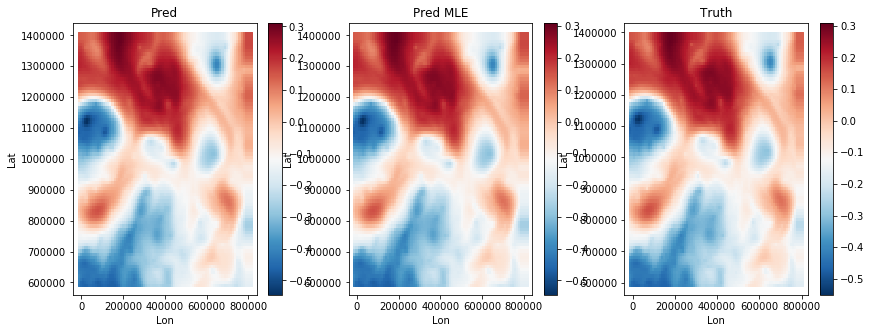

In [162]:
plt.figure(figsize=(14,5))

plt.subplot(131)
plt.scatter(test_pts[:,0], 
            test_pts[:,1],
            c=pred,
            s=50, marker='s',  cmap='RdBu_r')
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.colorbar()
plt.title('Pred')

plt.subplot(132)
plt.scatter(test_pts[:,0], 
            test_pts[:,1],
            c=pred_MLE,
            s=50, marker='s',  cmap='RdBu_r')
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.colorbar()
plt.title('Pred MLE')

plt.subplot(133)
plt.scatter(Xinput[:,0], 
            Xinput[:,1],
            c=Yinput,
            s=50, marker='s',  cmap='RdBu_r')
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.colorbar()
plt.title('Truth')

In [232]:
print(gp.parameter_names)
print(gp.parameter_vector)

('mean:value', 'white_noise:value', 'kernel:k1:log_constant', 'kernel:k2:metric:log_M_0_0', 'kernel:k2:metric:log_M_1_1')
[  0.         -27.40787756  -1.38621441  26.2446777   26.24465569]


In [168]:
print('Lx(km)='+str((np.exp(gp.parameter_vector[3]))**0.5/1e3))
print('Ly(km)='+str((np.exp(gp.parameter_vector[4]))**0.5/1e3))


Lx(km)=226.8319600733779
Ly(km)=214.2688083731999


In [169]:
pred_MLE_xr = xr.DataArray(pred_MLE.reshape(nx,nx), 
                           coords= [('XC',eta_sel.XC), 
                                    ('YC',eta_sel.YC)]) 

In [170]:
pred_ps = xrft.isotropic_powerspectrum(pred_MLE_xr, dim=['XC','YC'], window='True')

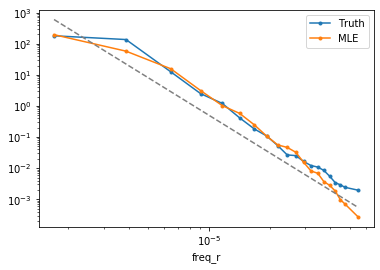

In [173]:
eta_ps.isel(time=1).plot(marker='.', label='Truth')
pred_ps.plot(marker='.', label='MLE')
plt.plot(eta_ps.freq_r, 5e-21*eta_ps.freq_r**-4, linestyle='--', color='gray')
plt.xscale('log')
plt.yscale('log')
plt.legend()

### 3. Estimate spectra with scattered data and correct kernel

In [306]:
num_samples = len(eta_sel.XC)*len(eta_sel.YC)
[XCg, YCg]  = np.meshgrid(eta_sel.XC.values, eta_sel.YC.values)

Xinput = np.zeros((num_samples, 2)) # 3 coordinates for lon, lat, time
Xinput[:,0] = XCg.reshape(-1)
Xinput[:,1] = YCg.reshape(-1)

Yinput = eta_sel.isel(time=0).values.reshape(-1)

In [307]:
rand_idx = np.random.randint(0, len(Xinput), int(len(Xinput)/10))

In [308]:
len(rand_idx)

640

In [309]:
Xinput_rand = Xinput[rand_idx,:]
Yinput_rand = Yinput[rand_idx]

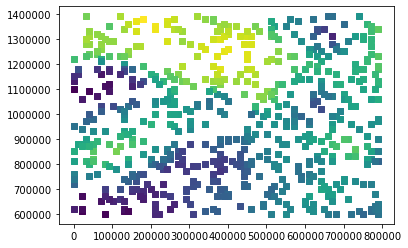

In [310]:
plt.scatter(Xinput_rand[:,0],
            Xinput_rand[:,1], 
            c = Yinput_rand, marker='s')

In [311]:
L_scale = 500e3
kernel_rand = 0.5*george.kernels.Matern32Kernel([L_scale**2, L_scale**2], 
                                           ndim=2)
print('Lx(km)='+str((np.exp(kernel_rand.parameter_vector[1]))**0.5/1e3))
print('Ly(km)='+str((np.exp(kernel_rand.parameter_vector[2]))**0.5/1e3))

Lx(km)=499.9999999999997
Ly(km)=499.9999999999997


In [312]:
gp_rand = george.GP(kernel_rand, fit_white_noise=True)

In [313]:
test_pts = np.array(np.meshgrid(np.linspace(0,800e3,80), 
                       np.linspace(600e3,1400e3,80),
                       )).reshape(2,-1).T

In [314]:
gp_rand.compute(Xinput_rand, 0.001)

In [317]:
pred_rand, pred_var_rand = gp_rand.predict(Yinput_rand, test_pts, return_var=True)

In [318]:
nx = len(eta_sel.XC)
pred_rand_xr = xr.DataArray(pred_rand.reshape(nx,nx),  
                           coords= [('XC',eta_sel.XC), 
                                    ('YC',eta_sel.YC)]) 

Text(0.5, 1.0, 'Truth')

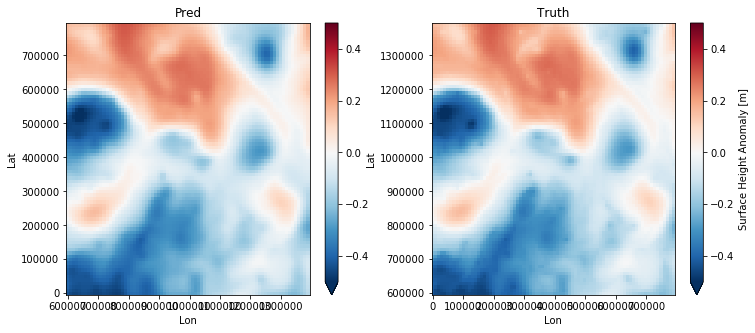

In [319]:
plt.figure(figsize=(12,5))

plt.subplot(121)
#plt.scatter(test_pts[:,0], 
#            test_pts[:,1],
#            c=pred,
#            s=50, marker='s',  cmap='RdBu_r')
pred_rand_xr.plot(vmin=-0.5)
plt.xlabel('Lon')
plt.ylabel('Lat')
#plt.colorbar()
plt.title('Pred')

plt.subplot(122)
#plt.scatter(Xinput[:,0], 
#            Xinput[:,1],
#            c=Yinput,
#            s=50, marker='s',  cmap='RdBu_r')
eta_sel.isel(time=0).plot(vmin=-0.5)
plt.xlabel('Lon')
plt.ylabel('Lat')
#plt.colorbar()
plt.title('Truth')

In [320]:
print("Initial ln-likelihood: {0:.2f}".format(
    gp_rand.log_likelihood(Yinput_rand)))

Initial ln-likelihood: 1577.23


In [321]:
from scipy.optimize import minimize

def neg_ln_like_rand(p):
    gp_rand.set_parameter_vector(p)
    return -gp_rand.log_likelihood(Yinput_rand)

def grad_neg_ln_like_rand(p):
    gp_rand.set_parameter_vector(p)
    return -gp_rand.grad_log_likelihood(Yinput_rand)

# these functions could probably be written better, and not be so hard coded,
# needed to change the insides because things were named with "_argo" here.

In [322]:
%%time 
result = minimize(neg_ln_like_rand, gp_rand.get_parameter_vector(),
                  jac=grad_neg_ln_like_rand)

CPU times: user 1.76 s, sys: 47.5 ms, total: 1.81 s
Wall time: 1.14 s


In [323]:
# Let's set the parameters to be these new ones, derived from MLE
gp_rand.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp_rand.log_likelihood(Yinput_rand)))


Final ln-likelihood: 1674.09


In [324]:
print(gp_rand.parameter_names)
print(gp_rand.parameter_vector)

('mean:value', 'white_noise:value', 'kernel:k1:log_constant', 'kernel:k2:metric:log_M_0_0', 'kernel:k2:metric:log_M_1_1')
[  0.         -27.40787756  -3.73465748  24.1568581   24.17561257]


In [325]:
print('Lx(km)='+str((np.exp(gp_rand.parameter_vector[3]))**0.5/1e3))
print('Ly(km)='+str((np.exp(gp_rand.parameter_vector[4]))**0.5/1e3))

Lx(km)=176.0334037690948
Ly(km)=177.69187452197752


In [326]:
pred_MLE_rand, pred_var_MLE_rand = gp_rand.predict(Yinput_rand, 
                                                   test_pts, return_var=True)

In [327]:
pred_MLE_rand_xr = xr.DataArray(pred_MLE_rand.reshape(nx,nx),  
                           coords= [('XC',eta_sel.XC), 
                                    ('YC',eta_sel.YC)]) 

In [343]:
pred_var_MLE_rand_xr = xr.DataArray(pred_var_MLE_rand.reshape(nx,nx),  
                           coords= [('XC',eta_sel.XC), 
                                    ('YC',eta_sel.YC)]) 

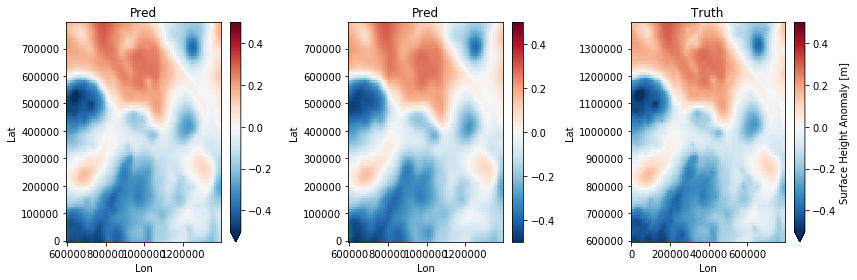

In [328]:
plt.figure(figsize=(12,4))

plt.subplot(131)
#plt.scatter(test_pts[:,0], 
#            test_pts[:,1],
#            c=pred,
#            s=50, marker='s',  cmap='RdBu_r')
pred_rand_xr.plot(vmin=-0.5)
plt.xlabel('Lon')
plt.ylabel('Lat')
#plt.colorbar()
plt.title('Pred')


plt.subplot(132)
#plt.scatter(test_pts[:,0], 
#            test_pts[:,1],
#            c=pred,
#            s=50, marker='s',  cmap='RdBu_r')
pred_MLE_rand_xr.plot(vmin=-0.5)
plt.xlabel('Lon')
plt.ylabel('Lat')
#plt.colorbar()
plt.title('Pred')

plt.subplot(133)
#plt.scatter(Xinput[:,0], 
#            Xinput[:,1],
#            c=Yinput,
#            s=50, marker='s',  cmap='RdBu_r')
eta_sel.isel(time=0).plot(vmin=-0.5)
plt.xlabel('Lon')
plt.ylabel('Lat')
#plt.colorbar()
plt.title('Truth')
plt.tight_layout()

In [329]:
pred_rand_ps = xrft.isotropic_powerspectrum(pred_MLE_rand_xr, dim=['XC','YC'], window='True')

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/xrft/xrft.py:589: RuntimeWarning: invalid value encountered in true_divide
  kr = np.bincount(kidx, weights=K.ravel()) / area
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/xrft/xrft.py:599: RuntimeWarning: invalid value encountered in true_divide
  / area) * kr


In [334]:
posterior_sample = gp_rand.sample_conditional(Yinput_rand, test_pts)

In [335]:
posterior_sample

array([-0.41727539, -0.44822386, -0.46348126, ...,  0.06295772,
        0.08045006,  0.086499  ])

In [336]:
posterior_sample_xr = xr.DataArray(posterior_sample.reshape(nx,nx),  
                           coords= [('XC',eta_sel.XC), 
                                    ('YC',eta_sel.YC)]) 

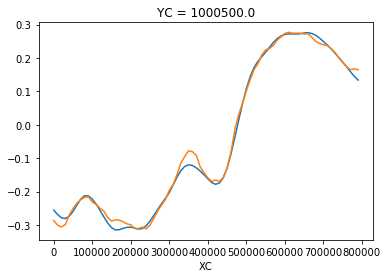

In [339]:
pred_MLE_rand_xr.sel(YC=1000e3, method='nearest').plot()
posterior_sampleior_sample_xr.sel(YC=1000e3, method='nearest').plot()

In [340]:
posterior_rand_ps = xrft.isotropic_powerspectrum(posterior_sampleior_sample_xr,
                                                 dim=['XC','YC'], window='True')

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/xrft/xrft.py:589: RuntimeWarning: invalid value encountered in true_divide
  kr = np.bincount(kidx, weights=K.ravel()) / area
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/xrft/xrft.py:599: RuntimeWarning: invalid value encountered in true_divide
  / area) * kr


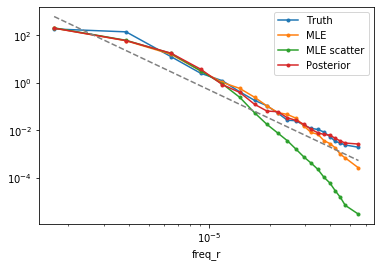

In [342]:
eta_ps.isel(time=1).plot(marker='.', label='Truth')
pred_ps.plot(marker='.', label='MLE')
pred_rand_ps.plot(marker='.', label='MLE scatter')
posterior_rand_ps.plot(marker='.', label='Posterior')
plt.plot(eta_ps.freq_r, 5e-21*eta_ps.freq_r**-4, linestyle='--', color='gray')
plt.xscale('log')
plt.yscale('log')
plt.legend()

# this seems to work quite well. 

### 4. Estimate spectra with scattered data and piecewise kernel

In [374]:
L_scale = 500e3
kernel_mix = (0.5*george.kernels.ExpKernel([L_scale**2, L_scale**2], ndim=2)# *grg.kernels.ExpSquaredKernel([lscale/100000000], ndim=1) 
        + 0.5*george.kernels.Matern32Kernel([L_scale**2, L_scale**2], ndim=2))

In [375]:
print(kernel_rand.parameter_names)
print(kernel_rand.parameter_vector)

('k1:log_constant', 'k2:metric:log_M_0_0', 'k2:metric:log_M_1_1')
[-3.73465748 24.1568581  24.17561257]


In [376]:
print(kernel_mix.parameter_names)
print(kernel_mix.parameter_vector)

('k1:k1:log_constant', 'k1:k2:metric:log_M_0_0', 'k1:k2:metric:log_M_1_1', 'k2:k1:log_constant', 'k2:k2:metric:log_M_0_0', 'k2:k2:metric:log_M_1_1')
[-1.38629436 26.24472675 26.24472675 -1.38629436 26.24472675 26.24472675]


In [377]:
gp_mix = george.GP(kernel_mix, fit_white_noise=True)

In [378]:
gp_mix.compute(Xinput_rand, 0.001)

In [379]:
pred_mix, pred_var_mix = gp_mix.predict(Yinput_rand, 
                                        test_pts, return_var=True)

In [380]:
nx = len(eta_sel.XC)
pred_mix_xr = xr.DataArray(pred_mix.reshape(nx,nx),  
                           coords= [('XC',eta_sel.XC), 
                                    ('YC',eta_sel.YC)]) 

In [381]:
print("Initial ln-likelihood: {0:.2f}".format(
    gp_mix.log_likelihood(Yinput_rand)))

Initial ln-likelihood: 675.00


In [382]:
def neg_ln_like_mix(p):
    gp_mix.set_parameter_vector(p)
    return -gp_mix.log_likelihood(Yinput_rand)

def grad_neg_ln_like_mix(p):
    gp_mix.set_parameter_vector(p)
    return -gp_mix.grad_log_likelihood(Yinput_rand)

In [383]:
%%time 
result = minimize(neg_ln_like_mix, gp_mix.get_parameter_vector(),
                  jac=grad_neg_ln_like_mix)

CPU times: user 7.75 s, sys: 165 ms, total: 7.91 s
Wall time: 4.21 s


In [384]:
# Let's set the parameters to be these new ones, derived from MLE
gp_mix.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp_mix.log_likelihood(Yinput_rand)))


Final ln-likelihood: 1674.09


In [385]:
pred_MLE_mix, pred_var_MLE_mix = gp_mix.predict(Yinput_rand, 
                                    test_pts, return_var=True)

In [386]:
pred_MLE_mix_xr = xr.DataArray(pred_MLE_mix.reshape(nx,nx),
                           coords= [('XC',eta_sel.XC), 
                                    ('YC',eta_sel.YC)]) 

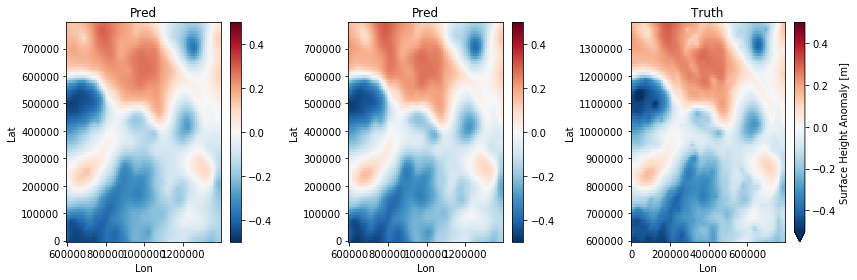

In [387]:
plt.figure(figsize=(12,4))

plt.subplot(131)
pred_mix_xr.plot(vmin=-0.5)
plt.xlabel('Lon')
plt.ylabel('Lat')
#plt.colorbar()
plt.title('Pred')


plt.subplot(132)
pred_MLE_mix_xr.plot(vmin=-0.5)
plt.xlabel('Lon')
plt.ylabel('Lat')
#plt.colorbar()
plt.title('Pred')

plt.subplot(133)
eta_sel.isel(time=0).plot(vmin=-0.5)
plt.xlabel('Lon')
plt.ylabel('Lat')
#plt.colorbar()
plt.title('Truth')
plt.tight_layout()

In [388]:
posterior_mix_sample = gp_mix.sample_conditional(Yinput_rand, test_pts)

In [389]:
posterior_mix_sample_xr = xr.DataArray(
                    posterior_mix_sample.reshape(nx,nx),  
                           coords= [('XC',eta_sel.XC), 
                                    ('YC',eta_sel.YC)]) 

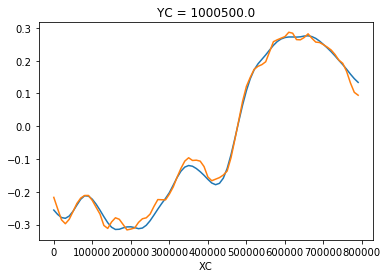

In [390]:
pred_MLE_mix_xr.sel(YC=1000e3, method='nearest').plot()
posterior_mix_sample_xr.sel(YC=1000e3, method='nearest').plot()

In [391]:
pred_mix_ps = xrft.isotropic_powerspectrum(pred_MLE_mix_xr, dim=['XC','YC'], window='True')
posterior_mix_ps = xrft.isotropic_powerspectrum(posterior_mix_sample_xr,
                                                 dim=['XC','YC'], window='True')

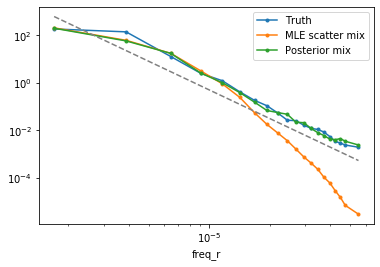

In [392]:
eta_ps.isel(time=1).plot(marker='.', label='Truth')

pred_mix_ps.plot(marker='.', label='MLE scatter mix')
posterior_mix_ps.plot(marker='.', label='Posterior mix')
plt.plot(eta_ps.freq_r, 5e-21*eta_ps.freq_r**-4, linestyle='--', color='gray')
plt.xscale('log')
plt.yscale('log')
plt.legend()

# this seems to work quite well. 

In [393]:
print(kernel_mix.parameter_names)
print(kernel_mix.parameter_vector)

('k1:k1:log_constant', 'k1:k2:metric:log_M_0_0', 'k1:k2:metric:log_M_1_1', 'k2:k1:log_constant', 'k2:k2:metric:log_M_0_0', 'k2:k2:metric:log_M_1_1')
[-21.30782717  33.78345358  32.94450237  -3.73465745  24.15685815
  24.17561263]
